A* Path: [(0, 0), (1, 0), (2, 0), (3, 0), (4, 0), (4, 1), (4, 2), (4, 3), (5, 3), (5, 4), (6, 4), (7, 4), (7, 5), (7, 6), (7, 7), (7, 8), (8, 8), (8, 9), (9, 9)]
Cost: 18
Destination Battery Level: 20%
Recharge Times: 1


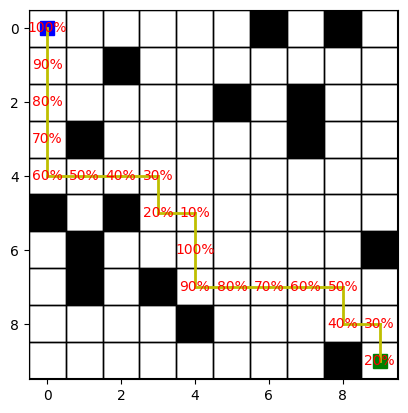

----------------------------------------
UCS Path: [(0, 0), (1, 0), (2, 0), (2, 1), (2, 2), (2, 3), (2, 4), (3, 4), (3, 5), (4, 5), (4, 6), (5, 6), (5, 7), (6, 7), (6, 8), (7, 8), (7, 9), (8, 9), (9, 9)]
Cost: 18
Destination Battery Level: 20%
Recharge Times: 1


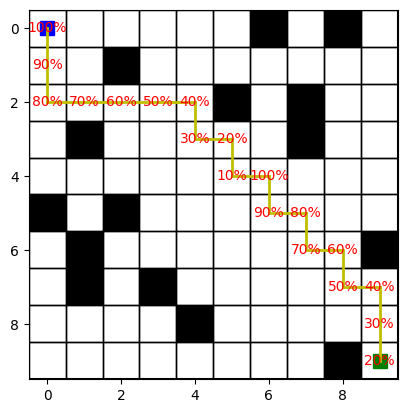

In [5]:
import numpy as np
import matplotlib.pyplot as plt
import heapq
import random

class PriorityQueue:
    def __init__(self):
        self.elements = []

    def empty(self):
        return len(self.elements) == 0

    def put(self, item, priority):
        heapq.heappush(self.elements, (priority, item))

    def get(self):
        return heapq.heappop(self.elements)[1]

class Node:
    def __init__(self, state, parent=None, action=None, path_cost=0):
        self.state = state
        self.parent = parent
        self.action = action
        self.path_cost = path_cost

    def __lt__(self, other):
        return self.path_cost < other.path_cost

class Environment:
    def __init__(self, size):
        self.size = size
        self.grid = self.generate_random_grid(size)
        self.initial = (0, 0)
        self.goal = (size - 1, size - 1)

    def generate_random_grid(self, size):
        grid = np.random.choice([0, 1], size=(size, size), p=[0.8, 0.2])
        grid[0][0] = 0
        grid[size - 1][size - 1] = 0
        return grid

    def actions(self, state):
        possible_actions = ['UP', 'DOWN', 'LEFT', 'RIGHT']
        x, y = state

        if x == 0 or self.grid[x - 1][y] == 1:
            possible_actions.remove('UP')
        if x == self.size - 1 or self.grid[x + 1][y] == 1:
            possible_actions.remove('DOWN')
        if y == 0 or self.grid[x][y - 1] == 1:
            possible_actions.remove('LEFT')
        if y == self.size - 1 or self.grid[x][y + 1] == 1:
            possible_actions.remove('RIGHT')

        return possible_actions

    def result(self, state, action):
        x, y = state
        if action == 'UP':
            return (x - 1, y)
        if action == 'DOWN':
            return (x + 1, y)
        if action == 'LEFT':
            return (x, y - 1)
        if action == 'RIGHT':
            return (x, y + 1)

    def is_goal(self, state):
        return state == self.goal

def heuristic(a, b):
    (x1, y1) = a
    (x2, y2) = b
    return abs(x1 - x2) + abs(y1 - y2)

class Agent:
    def __init__(self, env, battery_capacity=10):
        self.env = env
        self.battery_capacity = battery_capacity
        self.battery = battery_capacity
        self.recharge_times = 0

#A* STAR
    def a_star_search(self):
        start_node = Node(self.env.initial, path_cost=0)
        frontier = PriorityQueue()
        frontier.put(start_node, 0)
        came_from = {self.env.initial: None}
        cost_so_far = {self.env.initial: 0}
        self.battery = self.battery_capacity
        self.recharge_points = []
        self.recharge_times = 0

        while not frontier.empty():
            current_node = frontier.get()

            if self.env.is_goal(current_node.state):
                path = self.reconstruct_path(came_from, current_node.state)
                battery_levels = self.simulate_movement(path)
                return path, current_node.path_cost, battery_levels, self.recharge_times

            for action in self.env.actions(current_node.state):
                new_state = self.env.result(current_node.state, action)
                new_cost = cost_so_far[current_node.state] + 1

                if new_state not in cost_so_far or new_cost < cost_so_far[new_state]:
                    cost_so_far[new_state] = new_cost
                    priority = new_cost + heuristic(new_state, self.env.goal)
                    frontier.put(Node(new_state, current_node, action, new_cost), priority)
                    came_from[new_state] = current_node.state

        return [], 0, [], 0

#UCS
    def ucs_search(self):
        start_node = Node(self.env.initial, path_cost=0)
        frontier = PriorityQueue()
        frontier.put(start_node, 0)
        came_from = {self.env.initial: None}
        cost_so_far = {self.env.initial: 0}
        self.battery = self.battery_capacity
        self.recharge_points = []
        self.recharge_times = 0

        while not frontier.empty():
            current_node = frontier.get()

            if self.env.is_goal(current_node.state):
                path = self.reconstruct_path(came_from, current_node.state)
                battery_levels = self.simulate_movement(path)
                return path, current_node.path_cost, battery_levels, self.recharge_times

            for action in self.env.actions(current_node.state):
                new_state = self.env.result(current_node.state, action)
                new_cost = cost_so_far[current_node.state] + 1

                if new_state not in cost_so_far or new_cost < cost_so_far[new_state]:
                    cost_so_far[new_state] = new_cost
                    frontier.put(Node(new_state, current_node, action, new_cost), new_cost)
                    came_from[new_state] = current_node.state

        return [], 0, [], 0


    def reconstruct_path(self, came_from, current):
        path = []
        while current != self.env.initial:
            path.append(current)
            current = came_from[current]
        path.append(self.env.initial)
        path.reverse()
        return path

    def simulate_movement(self, path):
        self.battery = self.battery_capacity
        battery_levels = [100]  # Start with full battery
        self.recharge_times = 0

        for step in path[1:]:
            self.battery -= 1  # Decrease battery by 10% (1 movement)
            if self.battery == 0:
                self.recharge_times += 1
                self.battery = self.battery_capacity  # Recharge
                battery_levels.append(100)  # Reset to 100% after recharge
            else:
                battery_levels.append(self.battery * 10)  # Current battery level

        return battery_levels



def visualize_grid_and_path(grid, path, battery_levels, mark_point=None):
    grid_array = np.array(grid)
    fig, ax = plt.subplots()
    ax.imshow(grid_array, cmap='Greys', alpha=0)


    for i in range(len(grid)):
        for j in range(len(grid[0])):
            if grid[i][j] == 1:
                ax.add_patch(plt.Rectangle((j - 0.5, i - 0.5), 1, 1, color='black'))  # Obstacle
            else:
                ax.add_patch(plt.Rectangle((j - 0.5, i - 0.5), 1, 1, fill=False, edgecolor='black'))

    start = path[0]
    goal = path[-1]
    ax.plot(start[1], start[0], 'bs', markersize=10)
    ax.plot(goal[1], goal[0], 'gs', markersize=10)


    for i in range(len(path) - 1):
        x1, y1 = path[i]
        x2, y2 = path[i + 1]
        ax.plot([y1, y2], [x1, x2], 'y-', linewidth=2)

    # Annotate battery levels
    for i, (x, y) in enumerate(path):
        ax.text(y, x, f'{battery_levels[i]}%', ha='center', va='center', color='red')


    ax.plot([-0.5, -0.5, len(grid[0]) - 0.5, len(grid[0]) - 0.5, -0.5],
            [-0.5, len(grid) - 0.5, len(grid) - 0.5, -0.5, -0.5], color='black')

    if mark_point:
        ax.plot(mark_point[1], mark_point[0], 'ro')

    plt.show()


size = 10
env = Environment(size)
agent = Agent(env)

# A* search
a_star_path, a_star_cost, a_star_battery_levels, a_star_recharge_times = agent.a_star_search()
print(f"A* Path: {a_star_path}")
print(f"Cost: {a_star_cost}")

if a_star_battery_levels:
    print(f"Destination Battery Level: {a_star_battery_levels[-1]}%")
else:
    print("No battery levels available for A* path.")

print(f"Recharge Times: {a_star_recharge_times}")
visualize_grid_and_path(env.grid, a_star_path, a_star_battery_levels)


print("-" * 40)

# UCS search
ucs_path, ucs_cost, ucs_battery_levels, ucs_recharge_times = agent.ucs_search()
print(f"UCS Path: {ucs_path}")
print(f"Cost: {ucs_cost}")
print(f"Destination Battery Level: {ucs_battery_levels[-1]}%")
print(f"Recharge Times: {ucs_recharge_times}")
visualize_grid_and_path(env.grid, ucs_path, ucs_battery_levels)